<a href="https://colab.research.google.com/github/koussayinsat12/Anomalies-In-Multivariate-Time-Series-Data/blob/main/ChallengeNo1_P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Additional Libraries To Download

In [1]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185330 sha256=bd962314f503a03021c70cb12cc0ad87840637f94febee2eabdcc2d19cc0c30d
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod


In [2]:
!pip install eif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eif: filename=eif-2.0.2-cp310-cp310-linux_x86_64.whl size=283688 sha256=8d4ba0db4361ed5cdc5e4d336b9fd102724a56968bf9ac6ebecf79531bb300d9
  Stored in directory: /root/.cache/pip/wheels/11/9b/5e/16b95269f836d7f4bcc85f4f89d441179b1d4131a88d4587ee
Successfully built eif


In [3]:
!pip install combo

  Preparing metadata (setup.py) ... done
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42864 sha256=206dab0e799880de6d68efa37f7a523dbc5aea13d7748900c8708654d20d749f
  Stored in directory: /root/.cache/pip/wheels/7a/48/ff/0d6e1017d8bf3d844d332736fbb268dca767162779f93ff50a
Successfully built combo


In [4]:
!pip install adtk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import os
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time
import eif as iso
from adtk.detector import AutoregressionAD
from pyod.models.iforest import IForest
from sklearn.cluster import DBSCAN
from pyod.models.gmm import GMM
from pyod.models.ocsvm import OCSVM
from pyod.models.cblof import CBLOF
from pyod.models.abod import ABOD
from pyod.models.hbos import HBOS
from pyod.models.mcd import MCD
from pyod.models.combination import aom
from pyod.models.ecod import ECOD
from pyod.models.inne import INNE
from pyod.models.kde import KDE
from pyod.models.kpca import KPCA
from pyod.models.lmdd import LMDD
from pyod.models.loda import LODA
from pyod.models.lunar import LUNAR
from adtk.data import validate_series
from adtk.visualization import plot
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

## Essential Functions

In [6]:
def minmax_scale_data(X):
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    return X

In [7]:
def preprocess(initial_array):#preprocess an array
  initial_array=initial_array.values.reshape(1,-1)
  numeric_array = np.array(initial_array, dtype=float)  # Convert to numeric array
  numeric_array[np.isnan(numeric_array)] = False
  return np.array(numeric_array.flatten())

In [8]:
def return_data_frame(data,column):#return the values of a specific column in a dataframe
  data = data.copy()
  columns = [column]
  df = pd.DataFrame(columns=columns)
  df[column] = data[column]
  return df

In [9]:
def generate_time_series(num_points, trend_slope=0.1, seasonal_period=30, noise_scale=2.5, frequency=1.5,
                         anomaly_PG_index=None, slocal=None, endlocal=None, anomaly_d_index_start=None,
                         anomaly_d_index_end=None, anomaly_T_index_start=None, anomaly_T_index_end=None):#generate syntethic data
    np.random.seed(42)

    time = np.arange(0, num_points)
    trend = trend_slope * time
    seasonality = 10 * np.sin(frequency * np.pi * time / seasonal_period)
    noise = np.random.normal(loc=0, scale=noise_scale, size=num_points)
    time_series = trend + seasonality + noise

    # Anomaly point global and local
    anomaly_PL_index = np.where(time_series == np.max(time_series[slocal:endlocal]))
    anomaly_magnitude = 80
    time_series[anomaly_PG_index] += anomaly_magnitude
    time_series[anomaly_PL_index] -= 30
    print(anomaly_PL_index)
    # Anomaly deviant cycle
    noise_scale_anomaly = 0.1
    size_anomaly = anomaly_d_index_end - anomaly_d_index_start
    time_series[anomaly_d_index_start:anomaly_d_index_end] = (
        20 * np.sin(5 * np.pi * time[anomaly_d_index_start:anomaly_d_index_end] / seasonal_period) +
        np.random.normal(loc=0, scale=noise_scale_anomaly, size=size_anomaly)
    )

    # Temporary change
    noise_T_anomaly_scale = 0.5
    noise_T_anomaly_size = anomaly_T_index_end - anomaly_T_index_start
    time_series[anomaly_T_index_start:anomaly_T_index_end] += (
        35+ np.random.normal(loc=0, scale=noise_T_anomaly_scale, size=noise_T_anomaly_size)
    )

    df = pd.DataFrame({'Time': time, 'Value': time_series})
    df["Time"] = pd.to_datetime(df["Time"])
    df.set_index("Time", inplace=True)

    plot_time_series(df, anomaly_PG_index, anomaly_PL_index, anomaly_d_index_start,
                     anomaly_d_index_end, anomaly_T_index_start, anomaly_T_index_end)

    return df

def plot_time_series(df, anomaly_PG_index, anomaly_PL_index, anomaly_d_index_start, anomaly_d_index_end,
                     anomaly_T_index_start, anomaly_T_index_end):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Value'], label='Time Series')
    plt.scatter(df.index[anomaly_PG_index], df['Value'].iloc[anomaly_PG_index], color='red', marker='x', s=100,
                label='Global Anomaly Point')
    plt.scatter(df.index[anomaly_PL_index], df['Value'].iloc[anomaly_PL_index], color='red', marker='*', s=100,
                label='LOCAL Anomaly Point')
    plt.scatter(df.index[anomaly_d_index_start:anomaly_d_index_end], df['Value'].iloc[anomaly_d_index_start:anomaly_d_index_end],
                color='red', marker='+', s=100, label='Deviant cycle')
    plt.fill_between(df.index[anomaly_T_index_start:anomaly_T_index_end], df['Value'].iloc[anomaly_T_index_start:anomaly_T_index_end],
                     color='red', label='Temporary Change Anomaly', alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Time Series Data with Multiple Anomalies')
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
def change_binary_boolean(array):#convert the binary array to a boolean array
  if all(isinstance(p, bool) for p in array):
      b_array =array
  else:
      b_array = [arr == 1 for arr in array]
  return np.array(b_array)

In [11]:
def plot_anomalies(df,predictions,column):#plot the anomalies
    data=df.copy()
    b_predictions=change_binary_boolean(predictions)
    data["Timestamp"] = data.index
    data["predictions"]=np.array(b_predictions)
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(data["Timestamp"], data[column], label="Time Series Data", color="blue")
    plt.scatter(data[data["predictions"]]["Timestamp"], data[data["predictions"]]["Value"], color="red", label="Anomalies")

In [12]:
def extract_indices(array):#extract the positions of anoamlies in array
  return np.where(array==True)[0]

In [13]:
def compute_mad(scores):
    median = np.median(scores)
    abs_deviations = np.abs(scores - median)
    mad = np.median(abs_deviations)
    return mad
def set_threshold(scores, scaling_factor=1):#compute the threshold
    median = np.median(scores)
    mad = compute_mad(scores)
    threshold = median + (scaling_factor * mad)
    return threshold

In [14]:
def create_lagged_columns(df, column,p):#create a new dataframe  with p lagged column of a specific column
    new_df = pd.DataFrame()
    new_df[column]=df[column]
    for i in range(p):
        new_col_name = f'lag_{i+1}'
        new_df[new_col_name] = df[column].shift(i+1, fill_value=0)
    return new_df

## Algorithms

(array([125]),)


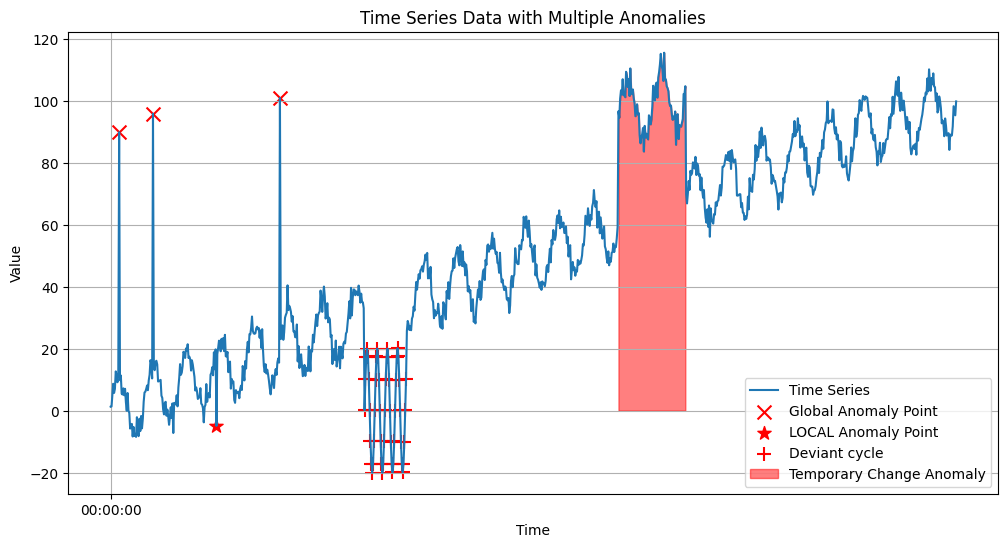

In [15]:
num_points = 1000
df=generate_time_series(num_points, anomaly_PG_index=[200,50,10], slocal=100, endlocal=150,
                     anomaly_d_index_start=300, anomaly_d_index_end=350,
                     anomaly_T_index_start=600, anomaly_T_index_end=680)

In [16]:
new_df=create_lagged_columns(df,"Value",2)

In [17]:
def train_isolation_forest(df,column=None,contamination=0.1,scaling=True,one_c=True):#train an isolation forest
  if one_c:
    X=return_data_frame(df,column)
  else:
    X=df.copy()
  if scaling==True:
    X=minmax_scale_data(X)
  start_time=time.time()
  model = IForest(contamination=contamination)
  model.fit(X)
  predictions=model.predict(X)
  end_time=time.time()
  dt=end_time-start_time
  l=[predictions,round(dt,3)]
  return l

In [18]:
predictions_if=train_isolation_forest(new_df,scaling=True,one_c=False)[0]#isloaton forest is good for deviant cycle but not good for temporary change

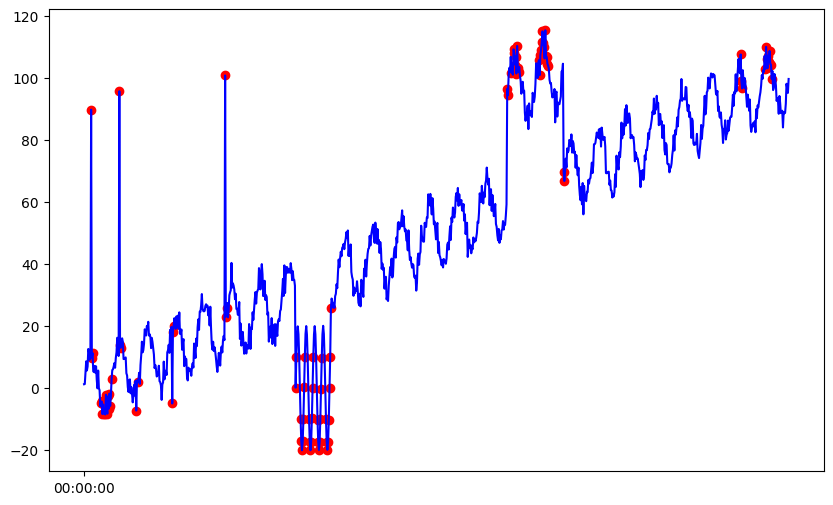

In [19]:
plot_anomalies(df,predictions_if,"Value")

In [20]:
def train_DBSCAN(data,column=None,one_c=True,eps=0.1, min_samples=12,scaling=True):#train DBSCAN
  if one_c:
    X=return_data_frame(data,column)
  else:
    X=data.copy()
  if scaling==True:
    X=minmax_scale_data(X)
  start_time=time.time()
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)
  dbscan.fit(X)
  predictions=dbscan.labels_
  predictions=np.where(np.array(predictions) == -1, 1, 0)
  end_time=time.time()
  dt=round(end_time-start_time,3)
  l=[predictions,dt]
  return l

In [21]:
predictions_db=train_DBSCAN(new_df,scaling=True,one_c=False)[0]#good for deviant cycle

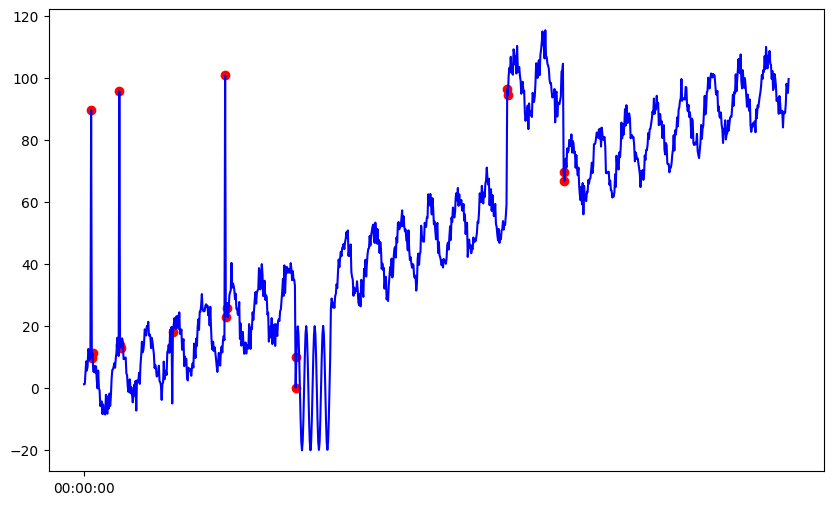

In [22]:
plot_anomalies(df,predictions_db,"Value")

In [23]:
def train_GMM(data,column=None,one_c=True,n_components=3,n_init=5,scaling=True):#train GMM
  if one_c:
    X=return_data_frame(data,column)
  else:
    X=data.copy()
  if scaling==True:
    X=minmax_scale_data(X)
  start_time=time.time()
  gm=GMM(n_components=n_components,n_init=n_init).fit(X)
  predictions=gm.predict(X)
  end_time=time.time()
  dt=end_time-start_time
  l=[predictions,round(dt,3)]
  return l

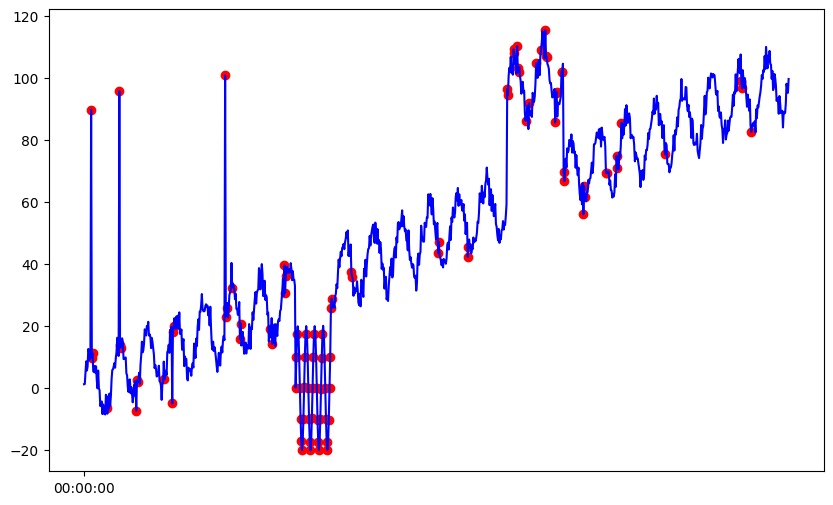

In [24]:
predictions_GMM=train_GMM(new_df,one_c=False,scaling=True)[0]
plot_anomalies(df,predictions_GMM,"Value")

In [25]:
def train_CBLOF(data,column=None,one_c=True,n_clusters=8, contamination=0.1,scaling=True): #train CBLOF
  if one_c:
    X=return_data_frame(data,column)
  else:
    X=data.copy()
  if scaling==True:
    X=minmax_scale_data(X)
  start_time=time.time()
  cblof=CBLOF(n_clusters=n_clusters,contamination=contamination).fit(X)
  predictions=cblof.predict(X)
  end_time=time.time()
  dt=end_time-start_time
  l=[predictions,round(dt,3)]
  return l

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


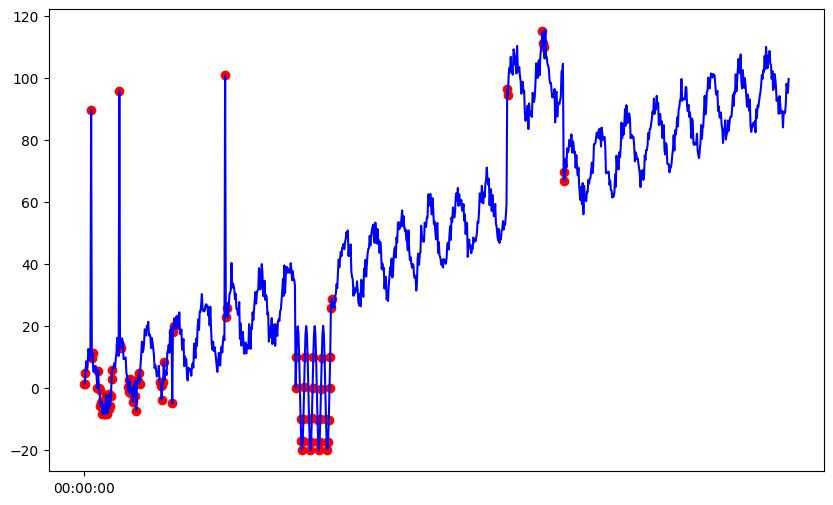

In [26]:
predictions_CBLOF=train_CBLOF(new_df,one_c=False,scaling=True)[0]
plot_anomalies(df,predictions_CBLOF,"Value")

In [27]:
def train_ABOD(data,column=None,one_c=True,contamination=0.1, n_neighbors=5, method='fast',scaling=True): #train ABOD
  if one_c:
    X=return_data_frame(data,column)
  else:
    X=data.copy()
  if scaling==True:
    X=minmax_scale_data(X)
  start_time=time.time()
  abod=ABOD(contamination=contamination,n_neighbors=n_neighbors,method=method).fit(X)
  predictions=abod.predict(X)
  end_time=time.time()
  dt=end_time-start_time
  l=[predictions,round(dt,3)]
  return l

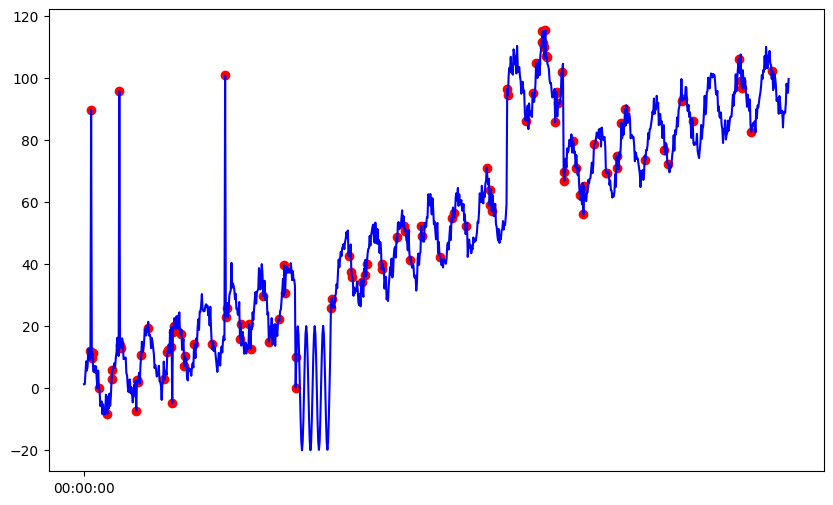

In [28]:
predictions_ABOD=train_ABOD(new_df,one_c=False,scaling=True)[0]
plot_anomalies(df,predictions_ABOD,"Value")

In [29]:
def train_HBOS(data,column=None,one_c=True,n_bins=10, alpha=0.1, tol=0.5, contamination=0.1,scaling=True):#train HBOS
  if one_c:
    X=return_data_frame(data,column)
  else:
    X=data.copy()
  if scaling==True:
    X=minmax_scale_data(X)
  start_time=time.time()
  hbos=HBOS(n_bins=n_bins,alpha=alpha,tol=tol,contamination=contamination).fit(X)
  predictions=hbos.predict(X)
  end_time=time.time()
  dt=end_time-start_time
  l=[predictions,round(dt,3)]
  return l

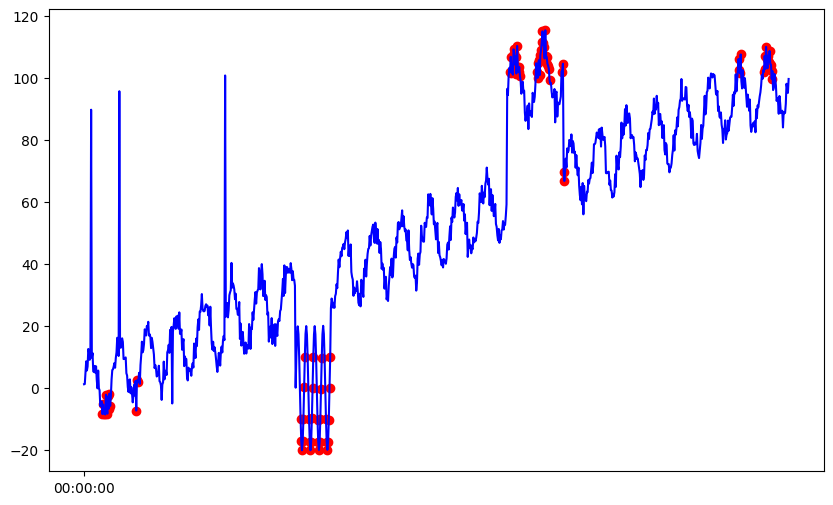

In [30]:
predictions_HBOS=train_HBOS(new_df,one_c=False,scaling=True)[0]
plot_anomalies(new_df,predictions_HBOS,"Value")

In [31]:
def train_MCD(data,column=None,one_c=True,contamination=0.2,scaling=True):#train MCD
  if one_c:
    X=return_data_frame(data,column)
  else:
    X=data.copy()
  if scaling==True:
    X=minmax_scale_data(X)
  start_time=time.time()
  mcd=MCD(contamination=contamination).fit(X)
  predictions=mcd.predict(X)
  end_time=time.time()
  dt=end_time-start_time
  l=[predictions,round(dt,3)]
  return l

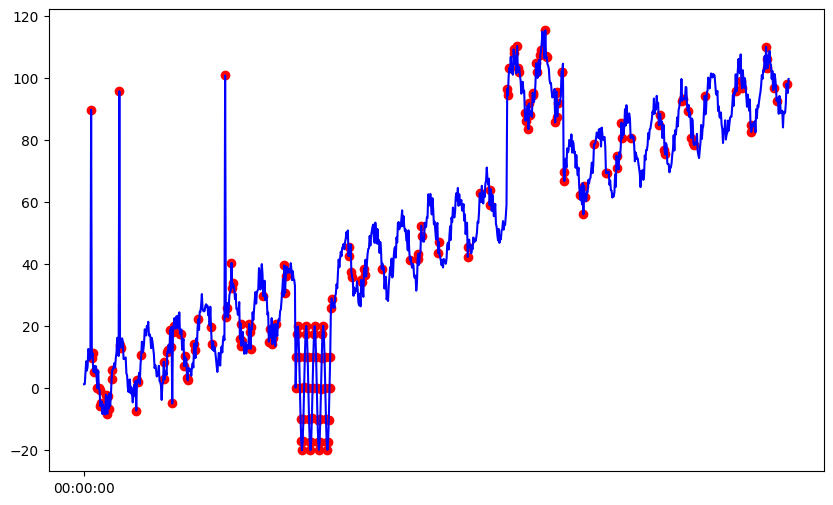

In [32]:
predictions_MCD=train_MCD(new_df,one_c=False,scaling=False)[0]
plot_anomalies(df,predictions_MCD,"Value")

In [33]:
def train_extended_isolation_forest(data,column=None,one_c=True,ntress=250,sample_size=128,scaling=True):#train EIF
  if one_c:
    X=return_data_frame(data,column)
  else:
    X=data.copy()
  if scaling==True:
    X=minmax_scale_data(X)
  start_time=time.time()
  F=iso.iForest(X, ntrees=ntress, sample_size=sample_size, ExtensionLevel=data.shape[1]-1)
  anomaly_scores=F.compute_paths(X_in=X)
  end_time=time.time()
  dt=end_time-start_time
  anomaly_scores=minmax_scale_data(anomaly_scores.reshape(-1,1))
  threshold=set_threshold(anomaly_scores)
  predictions=[]
  for score in anomaly_scores:
    if(score>=threshold):
      predictions.append(True)
    else:
      predictions.append(False)
  l=[predictions,round(dt,3)]
  return l

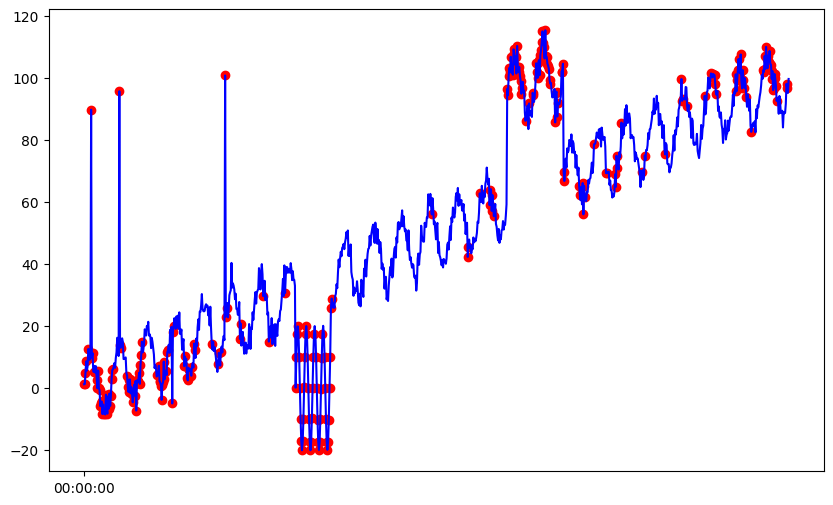

In [34]:
predictions_eif=train_extended_isolation_forest(new_df,one_c=False,scaling=True)[0]
plot_anomalies(df,predictions_eif,"Value")

In [35]:
def train_onesvm(data,column=None,one_c=True,kernel="rbf",nu=0.1,scaling=True):#train onesvm
  if one_c:
    X=return_data_frame(data,column)
  else:
    X=data.copy()
  if scaling==True:
    X=minmax_scale_data(data)
  start_time=time.time()
  model = OCSVM(kernel=kernel, nu=nu)
  model.fit(X)
  predictions=model.predict(X)
  end_time=time.time()
  dt=end_time-start_time
  l=[predictions,round(dt,3)]
  return l

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


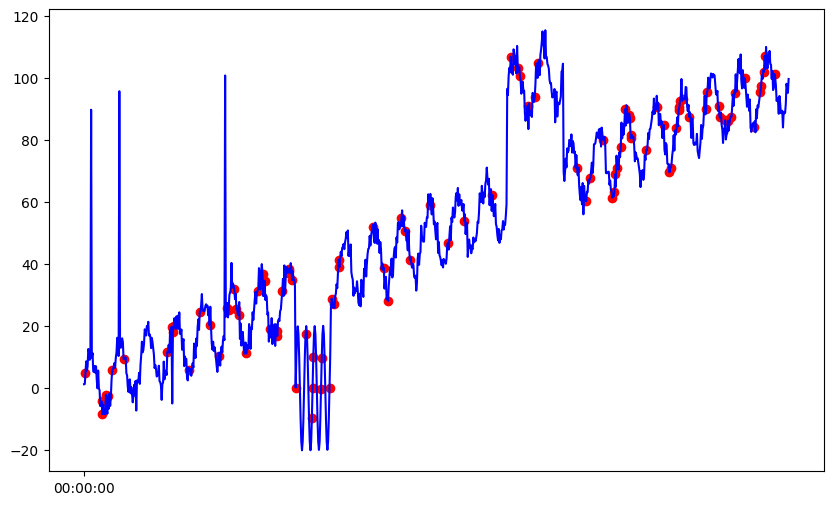

In [36]:
predictions_onesvm=train_onesvm(new_df,one_c=False,scaling=False)[0]
plot_anomalies(df,predictions_onesvm,"Value")

In [37]:
def train_ECOD(data,column=None,one_c=True,contamination=0.1,scaling=True):#train ECOD
  if one_c:
    X=return_data_frame(data,column)
  else:
    X=data.copy()
  if scaling==True:
    X=minmax_scale_data(data)
  start_time=time.time()
  model = ECOD(contamination=contamination)
  model.fit(X)
  predictions=model.predict(X)
  end_time=time.time()
  dt=end_time-start_time
  l=[predictions,round(dt,3)]
  return l

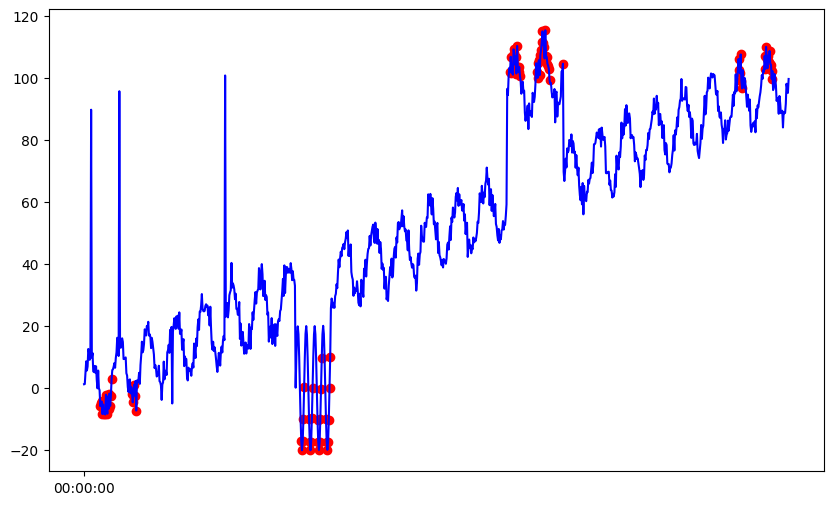

In [38]:
predictions_ECOD=train_ECOD(new_df,one_c=False,scaling=False)[0]
plot_anomalies(df,predictions_ECOD,"Value")

In [39]:
def train_INNE(data,column=None,one_c=True,n_estimators=200, max_samples='auto', contamination=0.1,scaling=True):#train INNE
  if one_c:
    X=return_data_frame(data,column)
  else:
    X=data.copy()
  if scaling==True:
    X=minmax_scale_data(data)
  start_time=time.time()
  model = INNE(n_estimators=n_estimators,max_samples=max_samples,contamination=contamination)
  model.fit(X)
  predictions=model.predict(X)
  end_time=time.time()
  dt=end_time-start_time
  l=[predictions,round(dt,3)]
  return l

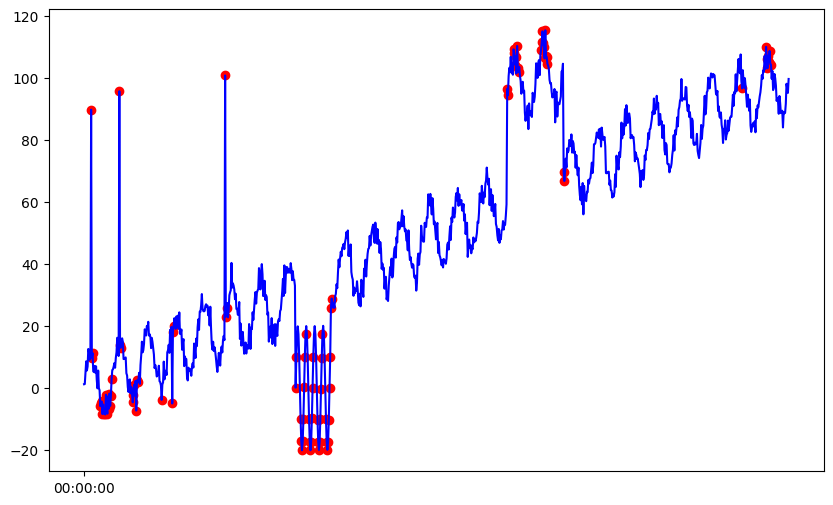

In [40]:
predictions_INNE=train_INNE(new_df,one_c=False,scaling=True)[0]
plot_anomalies(df,predictions_INNE,"Value")

In [41]:
def train_KDE(data,column=None,one_c=True,contamination=0.1, bandwidth=1.0,scaling=True):#train KDE
  if one_c:
    X=return_data_frame(data,column)
  else:
    X=data.copy()
  if scaling==True:
    X=minmax_scale_data(data)
  start_time=time.time()
  model = KDE(contamination=contamination, bandwidth=bandwidth)
  model.fit(X)
  predictions=model.predict(X)
  end_time=time.time()
  dt=end_time-start_time
  l=[predictions,round(dt,3)]
  return l

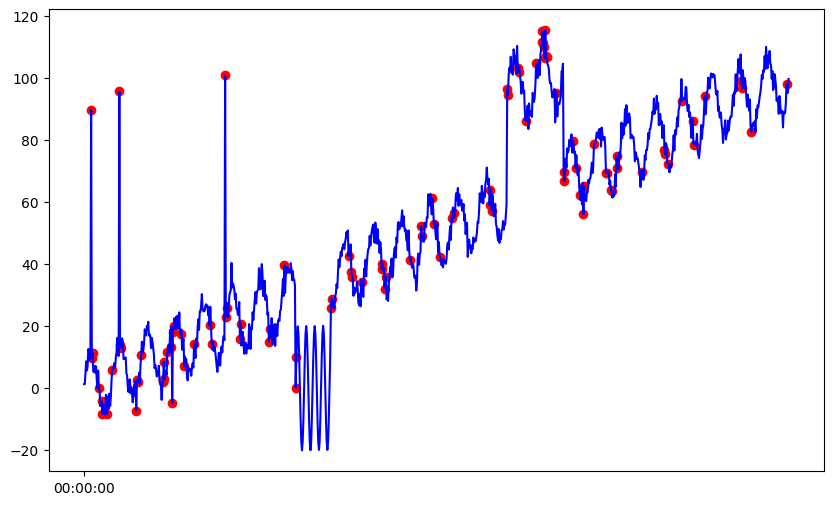

In [42]:
predictions_KDE=train_KDE(new_df,one_c=False,scaling=False)[0]
plot_anomalies(df,predictions_KDE,"Value")

In [43]:
def train_KPCA(data,column=None,one_c=True,contamination=0.1,scaling=True):#train KPCA
  if one_c:
    X=return_data_frame(data,column)
  else:
    X=data.copy()
  if scaling==True:
    X=minmax_scale_data(data)
  start_time=time.time()
  model = KPCA(contamination=contamination)
  model.fit(X)
  predictions=model.predict(X)
  end_time=time.time()
  dt=end_time-start_time
  l=[predictions,round(dt,3)]
  return l

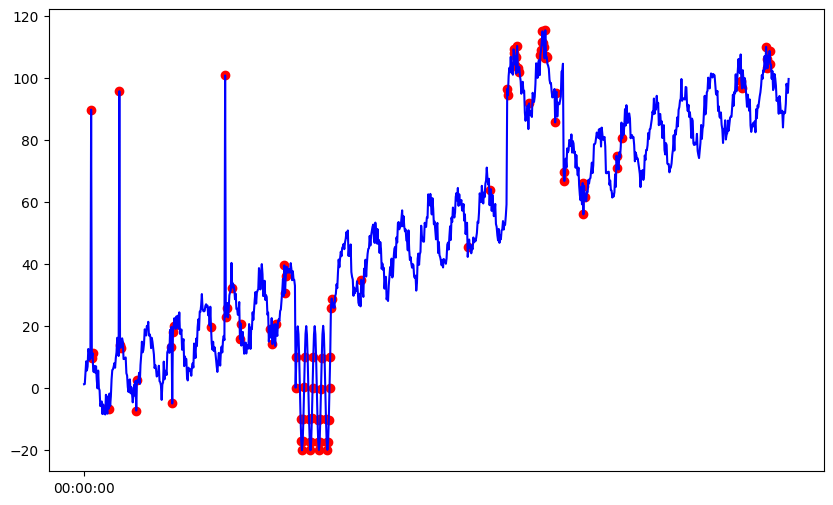

In [44]:
predictions_KPCA=train_KPCA(new_df,one_c=False,scaling=True)[0]
plot_anomalies(df,predictions_KPCA,"Value")

In [45]:
def train_LMDD(data,column=None,one_c=True,contamination=0.1,scaling=True):#train LMDD
  if one_c:
    X=return_data_frame(data,column)
  else:
    X=data.copy()
    X=X.values
  if scaling==True:
    X=minmax_scale_data(data)
  start_time=time.time()
  model = LMDD(contamination=contamination)
  model.fit(X)
  predictions=model.predict(X)
  end_time=time.time()
  dt=end_time-start_time
  l=[predictions,round(dt,3)]
  return l

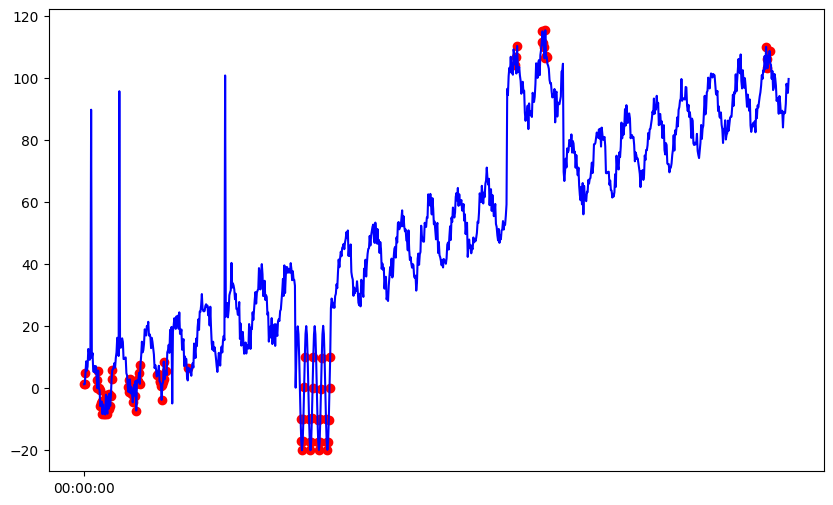

In [46]:
predictions_LMDD=train_LMDD(new_df,one_c=False,scaling=False)[0]
plot_anomalies(df,predictions_LMDD,"Value")

In [47]:
def train_LODA(data,column=None,one_c=True,contamination=0.1,scaling=True):#train LODA
  if one_c:
    X=return_data_frame(data,column)
  else:
    X=data.copy()
    X=X.values
  if scaling==True:
    X=minmax_scale_data(data)
  start_time=time.time()
  model = LODA(contamination=contamination)
  model.fit(X)
  predictions=model.predict(X)
  end_time=time.time()
  dt=end_time-start_time
  l=[predictions,round(dt,3)]
  return l

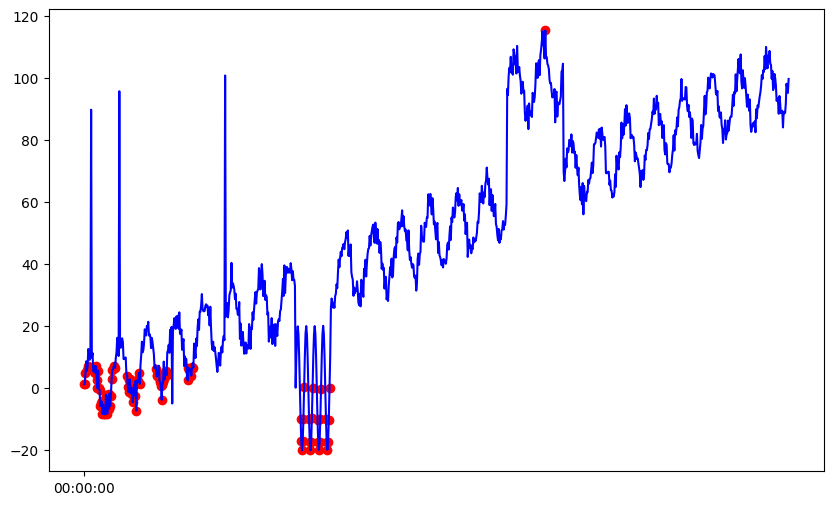

In [48]:
predictions_LODA=train_LODA(new_df,one_c=False,scaling=False)[0]
plot_anomalies(df,predictions_LODA,"Value")

In [49]:
def train_LUNAR(data,column=None,one_c=True,scaling=True):#train LUNAR
  if one_c:
    X=return_data_frame(data,column)
  else:
    X=data.copy()
    X=X.values
  if scaling==True:
    X=minmax_scale_data(data)
  start_time=time.time()
  model = LUNAR()
  model.fit(X)
  predictions=model.predict(X)
  end_time=time.time()
  dt=end_time-start_time
  l=[predictions,round(dt,3)]
  return l

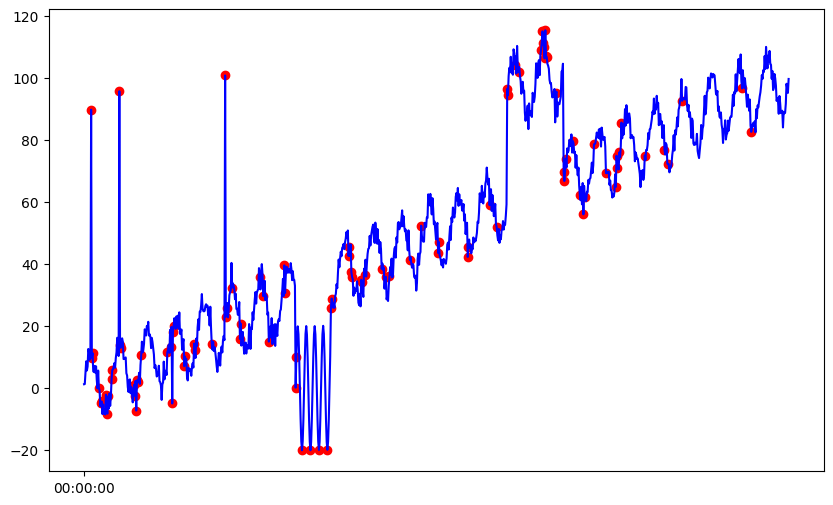

In [50]:
predictions_LUNAR=train_LUNAR(new_df,one_c=False,scaling=False)[0]
plot_anomalies(df,predictions_LUNAR,"Value")

In [51]:
df = validate_series(df)

[<Axes: >]

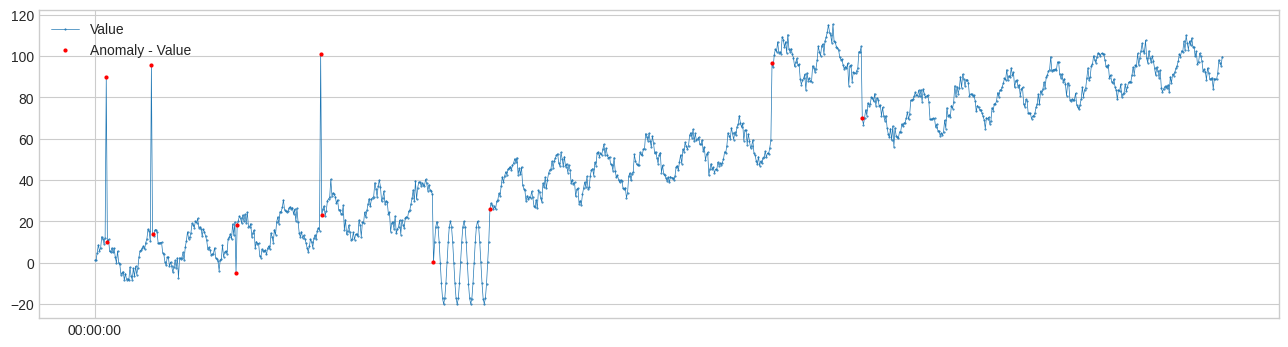

In [52]:
autoregression_ad = AutoregressionAD(n_steps=1, regressor=None,step_size=1, c=2.5)#train AutoregressionAD
anomalies_reg=autoregression_ad.fit_detect(df)
plot(df, anomaly=anomalies_reg, ts_markersize=1, anomaly_color='red', anomaly_tag="marker", anomaly_markersize=2)

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


[<Axes: >]

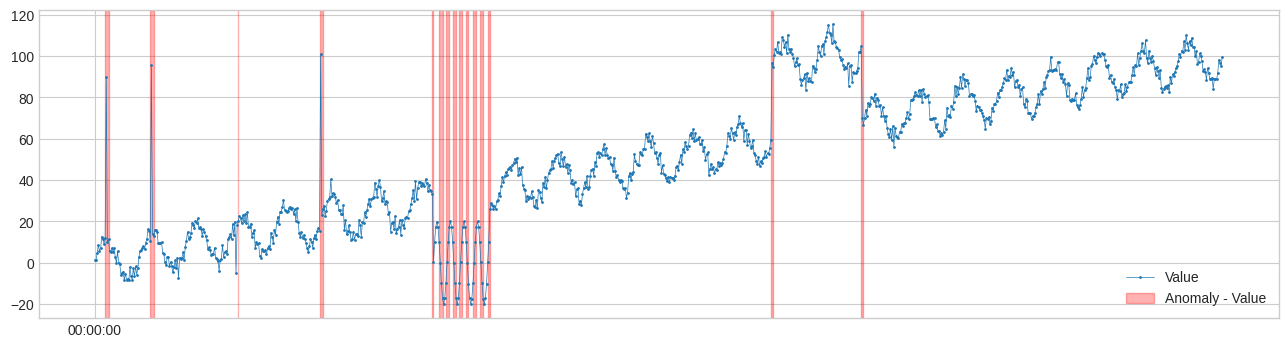

In [53]:
from adtk.detector import LevelShiftAD#train LevelShiftAD
level_shift_ad = LevelShiftAD(c=3.0, side='both', window=2)
anomalies_lsd = level_shift_ad.fit_detect(df)
plot(df, anomaly=anomalies_lsd, anomaly_color='red')

In [54]:
#combine the efficiency of autoregressionAD to detect global and local point anomalies and the efficiency of the HBOS in detecting collective anomalies
def combine_predictions(anomalies,predictions,scale=0.3):
  predictions=change_binary_boolean(predictions)
  anomalies=preprocess(anomalies)
  True_indices=extract_indices(anomalies)
  result = np.full(len(predictions), False, dtype=bool)
  for i in True_indices:
    for j in True_indices:
      if i!=j and i<j:
        length_indices=len(extract_indices(predictions[i:j+1]))
        th=int(scale*len(predictions[i:j+1]))
        if length_indices>th:
          print("start : ",i)
          print("end :",j)
          print("-----------------------")
          result[i:j]=True
  result[True_indices]=True_indices
  return result

In [55]:
final_result=combine_predictions(anomalies_reg,predictions_HBOS)

start :  300
end : 350
-----------------------
start :  600
end : 680
-----------------------


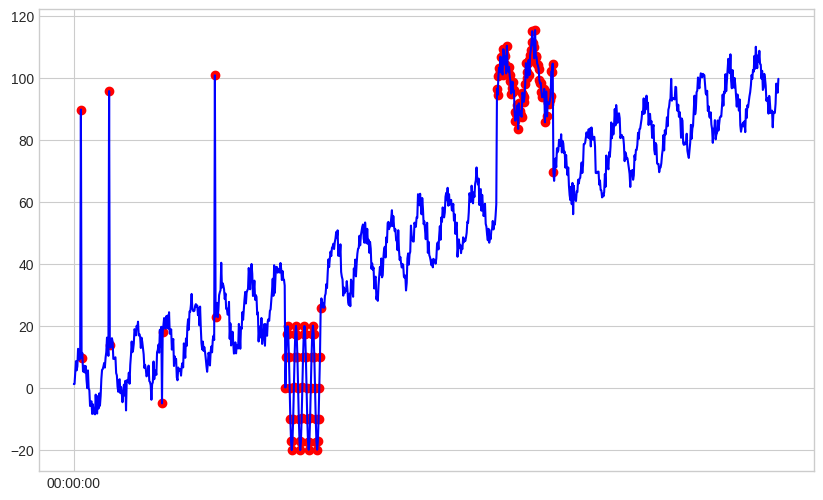

In [56]:
plot_anomalies(df,final_result,'Value')